In [1]:
%load_ext autoreload
%autoreload 2

import os, errno

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import numpy as np
import pandas as pd
from tqdm import tqdm
import pymc3 as pm

import matplotlib.pyplot as plt
%matplotlib inline

import glambox as gb

In [2]:
def make_sure_path_exists(path):
    try:
        os.makedirs(path)
    except OSError as exception:
        if exception.errno != errno.EEXIST:
            raise

In [3]:
make_sure_path_exists('examples/example_1/figures/')
make_sure_path_exists('examples/example_1/results/in_sample/traces/')
make_sure_path_exists('examples/example_1/results/in_sample/model_comparison/')
make_sure_path_exists('examples/example_1/results/out_of_sample/traces/')
make_sure_path_exists('examples/example_1/results/out_of_sample/predictions/')

# Exploring individual gaze biases

The first example is based on a study by Thomas et al. (2019). Here, the authors study the association between gaze allocation and choice behaviour on the level of the individual. Particularly, the authors explore whether (1) an association between gaze and choice is present at the individual level and (2) the strength of this association varies between individuals.

### 1. Simulating data

First, we simulate a dataset of 30 subjects, each performning 300 simple value-based choice trials. We assume that in each trial participants are asked to choose the item that they like most out of a set of three presented alternatives (similar to the task described in Krajbich & Rangel, 2011). While participants perform the task, their eye movements, choices and response times are measured. After completing all choice trials, participants further indicate their liking rating for each of the items presented in the choice task on a liking rating scale between 1 amd 10 (with 10 indicating strong liking and 1 indicating little liking). The resulting dataset contains a liking value for each choice item in each trial, the participants' choice and response, as well as their aggregated gaze data (describing the fraction of trial time that they spent looking at each item in the choice set). We assume that participant's gaze is distributed randomly with respect to the values of the items in a choice set.

In [4]:
n_subjects = 30
subjects = np.arange(n_subjects)
n_trials = 300
n_items = 3

To simulate individuals' choice behaviour, we define a set of generating model parameters for each individual. For simplicity, we use the GLAM parameter estimates obtained from Thomas et al. (2019) for the choice data of the subjects from Krajbich & Rangel (2011).

For the purpose of this example, we further assume that five subjects do not exhibit a gaze bias (i.e., that their choices are independent of the time that they spend looking at each item). To this end, we will set the $\gamma$ parameter of five randomly selected subjects to 1. 

In [5]:
np.random.seed(1)

# load empirical model parameters (taken from Thomas et al., 2019)
estimates = pd.read_csv('resources/individual_estimates_sec_nhb2019.csv')
kr2011 = estimates.loc[estimates['dataset'] == 'krajbich2011']
gen_parameters = dict(v=kr2011['v'].values,
                      gamma=kr2011['gamma'].values,
                      s=kr2011['s'].values,
                      tau=kr2011['tau'].values,
                      t0=np.zeros(len(kr2011)))

# define participants with no association between gaze and choice:
no_gaze_bias_subjects = np.sort(np.random.choice(n_subjects, 10, replace=False))
gaze_bias_subjects = np.array([s for s in subjects if s not in no_gaze_bias_subjects])
gen_parameters['gamma'][no_gaze_bias_subjects] = 1

The distribution of generating model parameters looks as follows:

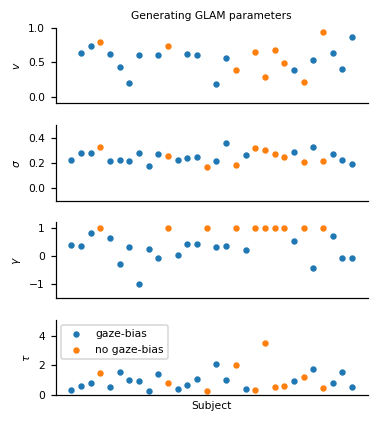

In [6]:
fig, axs = plt.subplots(4, 1, figsize=gb.plots.cm2inch(9,10), dpi=110, sharex=True)

for subject_set, color, label in zip([gaze_bias_subjects,
                                      no_gaze_bias_subjects],
                                      ['C0', 'C1'],
                                      ['gaze-bias', 'no gaze-bias']):
    # v
    axs[0].scatter(subject_set,
                   gen_parameters['v'][subject_set],
                   color=color,
                   s=10)
    axs[0].set_ylabel(r'$v$', fontsize=7)
    
    # sigma
    axs[1].scatter(subject_set,
                   gen_parameters['s'][subject_set],
                   color=color,
                   s=10)
    axs[1].set_ylabel(r'$\sigma$', fontsize=7)

    # gamma
    axs[2].scatter(subject_set,
                   gen_parameters['gamma'][subject_set],
                   color=color,
                   s=10)
    axs[2].set_ylabel(r'$\gamma$', fontsize=7)

    # tau
    axs[3].scatter(subject_set,
                   gen_parameters['tau'][subject_set],
                   color=color,
                   label=label,
                   s=10)
    axs[3].set_ylabel(r'$\tau$', fontsize=7)
    axs[3].set_xlabel('Subject', fontsize=7)
    

axs[0].set_title('Generating GLAM parameters', fontsize=7)
axs[0].set_ylim(-0.1, 1)
axs[1].set_ylim(-0.1, 0.5)
axs[2].set_ylim(-1.5, 1.2)
axs[3].set_ylim(0, 5.1)
axs[-1].legend(loc='upper left', frameon=True, fontsize=7)
for ax in axs:
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.tick_params(axis='both', which='major', labelsize=7)
    ax.set_xticks([])
    
fig.tight_layout()
fig.savefig('examples/example_1/figures/Supplementary_Figure_1_generating_parameters.png', dpi=330)

Subjects with no association of gaze allocation and choice behaviour:

In [7]:
no_gaze_bias_subjects

array([ 3, 10, 14, 17, 19, 20, 21, 22, 24, 26])

To subsequently simulate individuals' response behaviour, we use the *simulate_group* method of the GLAM model class. This method requires us to specify whether the individuals of this group are either simulated as individuals (and thereby independent of one another) or as part of a hierarchical parameter distribution (where the individual model parameters are drawn from a group distribution). If we specify the group as individual, the generating parameters need to be provided as a dictionary, containing one array of values per model parameter. 

In [8]:
np.random.seed(2)

glam = gb.GLAM()
glam.simulate_group(kind='individual',
                    n_individuals=n_subjects,
                    n_trials=n_trials,
                    n_items=n_items,
                    parameters=gen_parameters,
                    value_range=(1, 10))

We can then access the simulated data as part of our GLAM model instance.

In [9]:
data = glam.data.copy()

In [10]:
data.head()

,subject,trial,repeat,choice,rt,item_value_0,gaze_0,item_value_1,gaze_1,item_value_2,gaze_2,condition
0,0.0,0.0,0.0,0.0,1.678472,9,0.649142,9,0.224745,7,0.126113,condition_0
1,0.0,1.0,0.0,2.0,1.307034,3,0.332040,9,0.312176,8,0.355783,condition_0
2,0.0,2.0,0.0,2.0,1.324605,3,0.423884,2,0.192437,6,0.383680,condition_0
3,0.0,3.0,0.0,1.0,1.145805,5,0.195771,5,0.454379,6,0.349851,condition_0
4,0.0,4.0,0.0,2.0,1.065713,8,0.209319,4,0.382790,7,0.407891,condition_0


As this example is focussed on the individual level, we further create a summary dataframe, describing individuals' response behaviour on three behavioural metrics of individiual difference (as suggested in Thomas et al., 2019). Namely, individuals' mean response time, probability of choosing the item with the highest value from a choice set and a behavioural measure of the strength of the association between gaze allocation and choice behaviour (indicating the mean increase in choice probability for an item that was looked at longer than the others, after correcting for the inﬂuence of item value on choice probability (for further details on the behavioural gaze bias measure, see Thomas et al., 2019).

In [11]:
np.random.seed(3)

subject_data_summary = gb.analysis.aggregate_subject_level_data(data, n_items)

In [12]:
subject_data_summary.head()

rt                                                              \
             mean       std       min       max        se        q1        q3   
subject                                                                         
0.0      1.292315  0.477199  0.142598  4.708733  0.027597  1.025087  1.458560   
1.0      2.040758  0.878345  0.523410  6.317563  0.050796  1.413609  2.499227   
2.0      1.742749  0.720414  0.137617  4.912813  0.041663  1.261841  2.002483   
3.0      1.427180  0.697514  0.062293  5.375163  0.040338  0.967926  1.705945   
4.0      2.217397  0.755107  0.005503  4.586606  0.043669  1.662276  2.623872   

                  best_chosen gaze_influence  
              iqr        mean                 
subject                                       
0.0      0.433473    0.750000       0.189652  
1.0      1.085618    0.716667       0.202899  
2.0      0.740643    0.856667       0.033876  
3.0      0.738018    0.936667      -0.006805  
4.0      0.961595    0.850000       0.062939

### 2. Individual differences 

In a first step of our analysis, we explore differences in individuals' response behaviour on these three behavioural metrics. To create an overview of the distribution of individuals' values on the metrics, as well as the associations between them, we make use of the *individual_differences* function implemented in the GLAMbox *plots* module. This function allows specification of the 

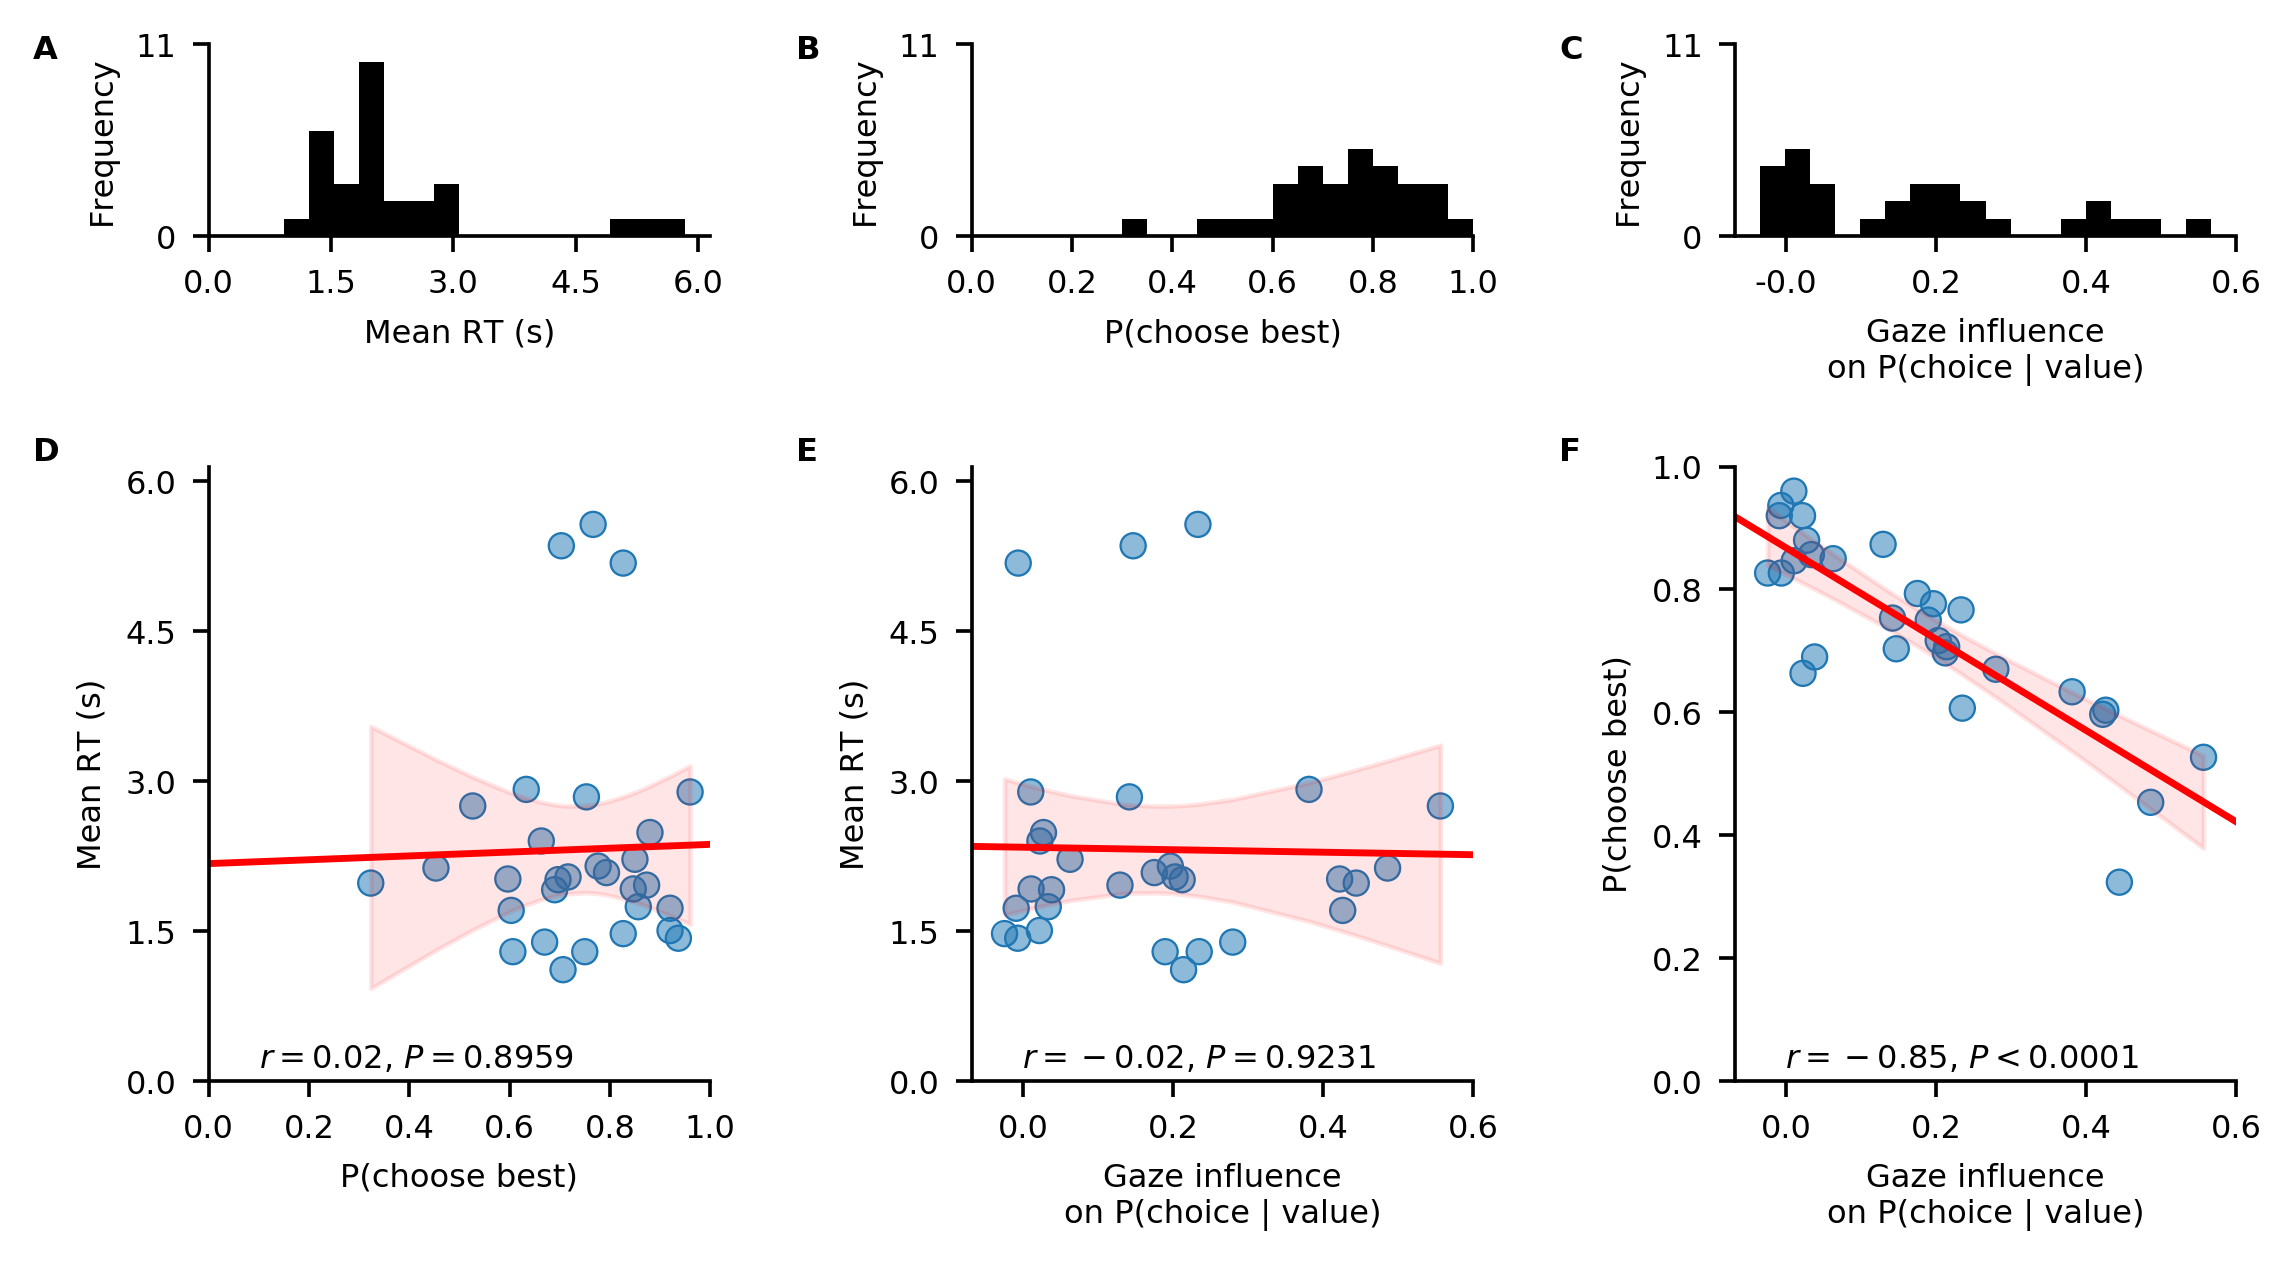

In [13]:
np.random.seed(4)

fig = gb.plots.plot_behaviour_associations(data=data)

fig.savefig('examples/example_1/figures/Figure_1_individual_differences.png', dpi=330)

We find that most individuals exhibit a positive association of gaze allocation and choice behaviour, as indicated by the behavioural gaze bias measure (b).

Further, we find that both, individuals' probability of choosing the best item and behavioural gaze bias, are not associated with their respose times. Interestingly, however, individuals' probability of choosing the best item from a choice set increases with decreasing strength of the behavioural gaze bias. Individuals with a strong association of gaze allocation and choice behaviour (as indicated by high values on the behavioural gaze bias measure) are therefore less likely to choose the item with the highest value from a choice set, when compared to individuals with a weak association of gaze and choice.

### 3. Individual model comparison

#### 3.1 Relative Model Fit

In a second step of our analysis, we want to test whether the response behaviour of each individual in the data is better described by a GLAM variant with or without gaze bias (i.e., a variant in which the gaze bias parameter $\gamma$ is fixed to 1). To this end, we first set up both model variants:

In [14]:
np.random.seed(5)

glam_bias = gb.GLAM(data=data, name='glam_bias')
glam_bias.make_model(kind='individual')

Generating single subject models for 30 subjects...


In [15]:
np.random.seed(6)

# for the no-gaze-bias variant, we set the gamma-parameter to 1, indicating no influence of gaze allocation on choice behaviour
glam_nobias = gb.GLAM(data=data, name='glam_nobias')
glam_nobias.make_model(kind='individual', gamma_val=1)

Generating single subject models for 30 subjects...


We fit both model variants to the data of each individual and compare their fit by means of the Widely Applicable Information Criterion (WAIC; Vehtari, Gelman, & Gabry, 2017). To fit each model, we utilize an MCMC sampling procedure with the Matroplois-hastings algorithm. For each model and parameter, we sample four chains. Each chain contains 5000 tuning samples (that we discard) and another 5000 samples that we use to determine individuals' parameter estimates. All resulting parameter traces were checked for convergence, before performing the model comparison.

In [16]:
n_tune = 5000
n_draws = 5000
n_chains = 4

In [17]:
np.random.seed(7)

glam_bias.fit(method='MCMC',
              tune=n_tune,
              draws=n_draws,
              chains=n_chains)

Fitting 30 model(s) using MCMC...
  Fitting model 1 of 30...


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [s]
>Metropolis: [gamma]
>Metropolis: [v]
Sampling 4 chains: 100%|██████████| 40000/40000 [00:30<00:00, 1315.39draws/s]
The number of effective samples is smaller than 10% for some parameters.


  Fitting model 2 of 30...


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [s]
>Metropolis: [gamma]
>Metropolis: [v]
Sampling 4 chains: 100%|██████████| 40000/40000 [00:30<00:00, 1301.23draws/s]
The number of effective samples is smaller than 10% for some parameters.


  Fitting model 3 of 30...


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [s]
>Metropolis: [gamma]
>Metropolis: [v]
Sampling 4 chains: 100%|██████████| 40000/40000 [00:30<00:00, 1300.95draws/s]
The number of effective samples is smaller than 10% for some parameters.


  Fitting model 4 of 30...


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [s]
>Metropolis: [gamma]
>Metropolis: [v]
Sampling 4 chains: 100%|██████████| 40000/40000 [00:31<00:00, 1266.78draws/s]
The number of effective samples is smaller than 10% for some parameters.


  Fitting model 5 of 30...


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [s]
>Metropolis: [gamma]
>Metropolis: [v]
Sampling 4 chains: 100%|██████████| 40000/40000 [00:30<00:00, 1292.95draws/s]
The number of effective samples is smaller than 10% for some parameters.


  Fitting model 6 of 30...


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [s]
>Metropolis: [gamma]
>Metropolis: [v]
Sampling 4 chains: 100%|██████████| 40000/40000 [00:31<00:00, 1284.61draws/s]
The number of effective samples is smaller than 10% for some parameters.


  Fitting model 7 of 30...


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [s]
>Metropolis: [gamma]
>Metropolis: [v]
Sampling 4 chains: 100%|██████████| 40000/40000 [00:30<00:00, 1293.75draws/s]
The number of effective samples is smaller than 10% for some parameters.


  Fitting model 8 of 30...


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [s]
>Metropolis: [gamma]
>Metropolis: [v]
Sampling 4 chains: 100%|██████████| 40000/40000 [00:30<00:00, 1292.45draws/s]
The number of effective samples is smaller than 10% for some parameters.


  Fitting model 9 of 30...


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [s]
>Metropolis: [gamma]
>Metropolis: [v]
Sampling 4 chains: 100%|██████████| 40000/40000 [00:31<00:00, 1285.49draws/s]
The number of effective samples is smaller than 10% for some parameters.


  Fitting model 10 of 30...


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [s]
>Metropolis: [gamma]
>Metropolis: [v]
Sampling 4 chains: 100%|██████████| 40000/40000 [00:31<00:00, 1287.27draws/s]
The number of effective samples is smaller than 10% for some parameters.


  Fitting model 11 of 30...


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [s]
>Metropolis: [gamma]
>Metropolis: [v]
Sampling 4 chains: 100%|██████████| 40000/40000 [00:31<00:00, 1284.06draws/s]
The number of effective samples is smaller than 10% for some parameters.


  Fitting model 12 of 30...


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [s]
>Metropolis: [gamma]
>Metropolis: [v]
Sampling 4 chains: 100%|██████████| 40000/40000 [00:31<00:00, 1279.57draws/s]
The number of effective samples is smaller than 10% for some parameters.


  Fitting model 13 of 30...


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [s]
>Metropolis: [gamma]
>Metropolis: [v]
Sampling 4 chains: 100%|██████████| 40000/40000 [00:31<00:00, 1266.32draws/s]
The number of effective samples is smaller than 10% for some parameters.


  Fitting model 14 of 30...


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [s]
>Metropolis: [gamma]
>Metropolis: [v]
Sampling 4 chains: 100%|██████████| 40000/40000 [00:32<00:00, 1237.59draws/s]
The number of effective samples is smaller than 10% for some parameters.


  Fitting model 15 of 30...


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [s]
>Metropolis: [gamma]
>Metropolis: [v]
Sampling 4 chains: 100%|██████████| 40000/40000 [00:31<00:00, 1279.50draws/s]
The number of effective samples is smaller than 10% for some parameters.


  Fitting model 16 of 30...


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [s]
>Metropolis: [gamma]
>Metropolis: [v]
Sampling 4 chains: 100%|██████████| 40000/40000 [00:31<00:00, 1283.37draws/s]
The number of effective samples is smaller than 25% for some parameters.


  Fitting model 17 of 30...


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [s]
>Metropolis: [gamma]
>Metropolis: [v]
Sampling 4 chains: 100%|██████████| 40000/40000 [00:31<00:00, 1283.39draws/s]
The number of effective samples is smaller than 10% for some parameters.


  Fitting model 18 of 30...


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [s]
>Metropolis: [gamma]
>Metropolis: [v]
Sampling 4 chains: 100%|██████████| 40000/40000 [00:31<00:00, 1278.46draws/s]
The number of effective samples is smaller than 10% for some parameters.


  Fitting model 19 of 30...


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [s]
>Metropolis: [gamma]
>Metropolis: [v]
Sampling 4 chains: 100%|██████████| 40000/40000 [00:31<00:00, 1278.78draws/s]
The number of effective samples is smaller than 10% for some parameters.


  Fitting model 20 of 30...


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [s]
>Metropolis: [gamma]
>Metropolis: [v]
Sampling 4 chains: 100%|██████████| 40000/40000 [00:31<00:00, 1279.67draws/s]
The number of effective samples is smaller than 10% for some parameters.


  Fitting model 21 of 30...


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [s]
>Metropolis: [gamma]
>Metropolis: [v]
Sampling 4 chains: 100%|██████████| 40000/40000 [00:30<00:00, 1311.78draws/s]
The number of effective samples is smaller than 25% for some parameters.


  Fitting model 22 of 30...


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [s]
>Metropolis: [gamma]
>Metropolis: [v]
Sampling 4 chains: 100%|██████████| 40000/40000 [00:31<00:00, 1276.63draws/s]
The number of effective samples is smaller than 10% for some parameters.


  Fitting model 23 of 30...


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [s]
>Metropolis: [gamma]
>Metropolis: [v]
Sampling 4 chains: 100%|██████████| 40000/40000 [00:31<00:00, 1272.31draws/s]
The number of effective samples is smaller than 10% for some parameters.


  Fitting model 24 of 30...


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [s]
>Metropolis: [gamma]
>Metropolis: [v]
Sampling 4 chains: 100%|██████████| 40000/40000 [00:31<00:00, 1286.49draws/s]
The number of effective samples is smaller than 10% for some parameters.


  Fitting model 25 of 30...


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [s]
>Metropolis: [gamma]
>Metropolis: [v]
Sampling 4 chains: 100%|██████████| 40000/40000 [00:31<00:00, 1275.65draws/s]
The number of effective samples is smaller than 10% for some parameters.


  Fitting model 26 of 30...


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [s]
>Metropolis: [gamma]
>Metropolis: [v]
Sampling 4 chains: 100%|██████████| 40000/40000 [00:31<00:00, 1281.44draws/s]
The number of effective samples is smaller than 10% for some parameters.


  Fitting model 27 of 30...


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [s]
>Metropolis: [gamma]
>Metropolis: [v]
Sampling 4 chains: 100%|██████████| 40000/40000 [00:31<00:00, 1275.94draws/s]
The number of effective samples is smaller than 10% for some parameters.


  Fitting model 28 of 30...


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [s]
>Metropolis: [gamma]
>Metropolis: [v]
Sampling 4 chains: 100%|██████████| 40000/40000 [00:31<00:00, 1275.33draws/s]
The number of effective samples is smaller than 10% for some parameters.


  Fitting model 29 of 30...


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [s]
>Metropolis: [gamma]
>Metropolis: [v]
Sampling 4 chains: 100%|██████████| 40000/40000 [00:31<00:00, 1258.98draws/s]
The number of effective samples is smaller than 10% for some parameters.


  Fitting model 30 of 30...


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [s]
>Metropolis: [gamma]
>Metropolis: [v]
Sampling 4 chains: 100%|██████████| 40000/40000 [00:31<00:00, 1272.49draws/s]
The number of effective samples is smaller than 10% for some parameters.


/!\ Automatically setting parameter precision...


In [18]:
np.random.seed(8)

glam_nobias.fit(method='MCMC',
                tune=n_tune,
                draws=n_draws,
                chains=n_chains)

Fitting 30 model(s) using MCMC...
  Fitting model 1 of 30...


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [s]
>Metropolis: [v]
Sampling 4 chains: 100%|██████████| 40000/40000 [00:20<00:00, 1931.05draws/s]
The number of effective samples is smaller than 10% for some parameters.


  Fitting model 2 of 30...


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [s]
>Metropolis: [v]
Sampling 4 chains: 100%|██████████| 40000/40000 [00:20<00:00, 1941.34draws/s]
The number of effective samples is smaller than 10% for some parameters.


  Fitting model 3 of 30...


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [s]
>Metropolis: [v]
Sampling 4 chains: 100%|██████████| 40000/40000 [00:23<00:00, 1706.90draws/s]
The number of effective samples is smaller than 10% for some parameters.


  Fitting model 4 of 30...


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [s]
>Metropolis: [v]
Sampling 4 chains: 100%|██████████| 40000/40000 [00:22<00:00, 1750.74draws/s]
The number of effective samples is smaller than 10% for some parameters.


  Fitting model 5 of 30...


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [s]
>Metropolis: [v]
Sampling 4 chains: 100%|██████████| 40000/40000 [00:22<00:00, 1778.95draws/s]
The number of effective samples is smaller than 10% for some parameters.


  Fitting model 6 of 30...


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [s]
>Metropolis: [v]
Sampling 4 chains: 100%|██████████| 40000/40000 [00:22<00:00, 1749.17draws/s]
The number of effective samples is smaller than 10% for some parameters.


  Fitting model 7 of 30...


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [s]
>Metropolis: [v]
Sampling 4 chains: 100%|██████████| 40000/40000 [00:23<00:00, 1698.13draws/s]
The number of effective samples is smaller than 10% for some parameters.


  Fitting model 8 of 30...


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [s]
>Metropolis: [v]
Sampling 4 chains: 100%|██████████| 40000/40000 [00:22<00:00, 1752.89draws/s]
The number of effective samples is smaller than 10% for some parameters.


  Fitting model 9 of 30...


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [s]
>Metropolis: [v]
Sampling 4 chains: 100%|██████████| 40000/40000 [00:22<00:00, 1748.22draws/s]
The number of effective samples is smaller than 25% for some parameters.


  Fitting model 10 of 30...


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [s]
>Metropolis: [v]
Sampling 4 chains: 100%|██████████| 40000/40000 [00:22<00:00, 1779.69draws/s]
The number of effective samples is smaller than 10% for some parameters.


  Fitting model 11 of 30...


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [s]
>Metropolis: [v]
Sampling 4 chains: 100%|██████████| 40000/40000 [00:23<00:00, 1669.64draws/s]
The number of effective samples is smaller than 10% for some parameters.


  Fitting model 12 of 30...


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [s]
>Metropolis: [v]
Sampling 4 chains: 100%|██████████| 40000/40000 [00:23<00:00, 1705.45draws/s]
The number of effective samples is smaller than 10% for some parameters.


  Fitting model 13 of 30...


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [s]
>Metropolis: [v]
Sampling 4 chains: 100%|██████████| 40000/40000 [00:22<00:00, 1789.80draws/s]
The number of effective samples is smaller than 10% for some parameters.


  Fitting model 14 of 30...


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [s]
>Metropolis: [v]
Sampling 4 chains: 100%|██████████| 40000/40000 [00:22<00:00, 1776.07draws/s]
The number of effective samples is smaller than 10% for some parameters.


  Fitting model 15 of 30...


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [s]
>Metropolis: [v]
Sampling 4 chains: 100%|██████████| 40000/40000 [00:23<00:00, 1733.82draws/s]
The number of effective samples is smaller than 10% for some parameters.


  Fitting model 16 of 30...


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [s]
>Metropolis: [v]
Sampling 4 chains: 100%|██████████| 40000/40000 [00:23<00:00, 1692.22draws/s]
The number of effective samples is smaller than 10% for some parameters.


  Fitting model 17 of 30...


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [s]
>Metropolis: [v]
Sampling 4 chains: 100%|██████████| 40000/40000 [00:22<00:00, 1764.09draws/s]
The number of effective samples is smaller than 10% for some parameters.


  Fitting model 18 of 30...


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [s]
>Metropolis: [v]
Sampling 4 chains: 100%|██████████| 40000/40000 [00:22<00:00, 1777.84draws/s]
The number of effective samples is smaller than 10% for some parameters.


  Fitting model 19 of 30...


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [s]
>Metropolis: [v]
Sampling 4 chains: 100%|██████████| 40000/40000 [00:23<00:00, 1737.96draws/s]
The number of effective samples is smaller than 10% for some parameters.


  Fitting model 20 of 30...


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [s]
>Metropolis: [v]
Sampling 4 chains: 100%|██████████| 40000/40000 [00:23<00:00, 1697.29draws/s]
The number of effective samples is smaller than 10% for some parameters.


  Fitting model 21 of 30...


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [s]
>Metropolis: [v]
Sampling 4 chains: 100%|██████████| 40000/40000 [00:22<00:00, 1781.37draws/s]
The number of effective samples is smaller than 25% for some parameters.


  Fitting model 22 of 30...


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [s]
>Metropolis: [v]
Sampling 4 chains: 100%|██████████| 40000/40000 [00:22<00:00, 1758.02draws/s]
The number of effective samples is smaller than 10% for some parameters.


  Fitting model 23 of 30...


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [s]
>Metropolis: [v]
Sampling 4 chains: 100%|██████████| 40000/40000 [00:22<00:00, 1762.24draws/s]
The number of effective samples is smaller than 10% for some parameters.


  Fitting model 24 of 30...


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [s]
>Metropolis: [v]
Sampling 4 chains: 100%|██████████| 40000/40000 [00:23<00:00, 1672.76draws/s]
The number of effective samples is smaller than 10% for some parameters.


  Fitting model 25 of 30...


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [s]
>Metropolis: [v]
Sampling 4 chains: 100%|██████████| 40000/40000 [00:23<00:00, 1701.48draws/s]
The number of effective samples is smaller than 10% for some parameters.


  Fitting model 26 of 30...


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [s]
>Metropolis: [v]
Sampling 4 chains: 100%|██████████| 40000/40000 [00:22<00:00, 1765.12draws/s]
The number of effective samples is smaller than 10% for some parameters.


  Fitting model 27 of 30...


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [s]
>Metropolis: [v]
Sampling 4 chains: 100%|██████████| 40000/40000 [00:22<00:00, 1753.78draws/s]
The number of effective samples is smaller than 10% for some parameters.


  Fitting model 28 of 30...


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [s]
>Metropolis: [v]
Sampling 4 chains: 100%|██████████| 40000/40000 [00:23<00:00, 1703.76draws/s]
The number of effective samples is smaller than 10% for some parameters.


  Fitting model 29 of 30...


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [s]
>Metropolis: [v]
Sampling 4 chains: 100%|██████████| 40000/40000 [00:23<00:00, 1667.33draws/s]
The number of effective samples is smaller than 10% for some parameters.


  Fitting model 30 of 30...


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [s]
>Metropolis: [v]
Sampling 4 chains: 100%|██████████| 40000/40000 [00:22<00:00, 1775.38draws/s]
The number of effective samples is smaller than 10% for some parameters.


/!\ Automatically setting parameter precision...


Convergence check:

In [19]:
def check_convergence(summary, varnames=['v', 's', 'tau'],
                      n_eff_required=100, gelman_rubin_criterion=0.05):
    varnames = [varname + '__0_0' for varname in varnames]
    enough_eff_samples = np.all(summary.loc[varnames]['n_eff'] > n_eff_required)
    good_gelman = np.all(np.abs(summary.loc[varnames]['Rhat'] - 1.0) < gelman_rubin_criterion)
    if not enough_eff_samples or not good_gelman:
        return False
    else:
        return True

In [20]:
np.all([check_convergence(pm.summary(trace), varnames=['v', 's', 'gamma', 'tau']) for trace in glam_bias.trace])

True

In [21]:
np.all([check_convergence(pm.summary(trace), varnames=['v', 's', 'tau']) for trace in glam_nobias.trace])

True

Saving traces and traceplots for visual inspection:

In [22]:
for subject, subject_trace in enumerate(glam_bias.trace):
    gb.plots.traceplot(subject_trace)
    plt.savefig('examples/example_1/results/in_sample/traces/sub_{}_gaze_bias_model_trace.png'.format(subject), dpi=330)
    plt.close()
    pm.trace_to_dataframe(subject_trace).to_csv(
        'examples/example_1/results/in_sample/traces/sub_{}_gaze_bias_model_trace.csv'.format(subject))

In [23]:
for subject, subject_trace in enumerate(glam_nobias.trace):
    gb.plots.traceplot(subject_trace)
    plt.savefig('examples/example_1/results/in_sample/traces/sub_{}_no_gaze_bias_model_trace.png'.format(subject), dpi=330)
    plt.close()
    pm.trace_to_dataframe(subject_trace).to_csv(
        'examples/example_1/results/in_sample/traces/sub_{}_no_gaze_bias_model_trace.csv'.format(subject))

After convergence has been established for all parameter traces (for details on the suggested convergence criteria, see Methods), we perform a model comparison on the individual level, using the `compare` function which wraps the function of the same name from the PyMC3 library. The `compare` function takes as input a list of fitted model instances that are to be compared. Additional keyword arguments can be given and are passed on to PyMC3 function. This allows the user, for example, to specify the information criterion used for the comparison via the `ic` argument (`'WAIC` or `LOO'` for Leave-One-Out cross validation).

It returns a table containing an estimate of the specified information criterion, standard errors, difference to the best-fitting model, standard error of the difference, and other output variables from PyMC3 for each inputted model (and subject, if individually estimated models were given):

In [24]:
comparison_df = gb.compare(models=[glam_bias, glam_nobias])
comparison_df

,subject,model,WAIC,pWAIC,dWAIC,weight,SE,dSE,var_warn
0,0,glam_bias,523.6,5.75,0,0.94,50.25,0,0
1,0,glam_nobias,645.09,3.64,121.49,0.06,44.15,23.56,0
2,1,glam_bias,1097.86,3.69,0,1,40.32,0,0
3,1,glam_nobias,1185.02,2.85,87.16,0,38.22,18,0
4,2,glam_bias,832.43,4.02,0,1,41.15,0,0
5,2,glam_nobias,847.56,3.02,15.12,0,41.33,7.74,0
6,3,glam_nobias,690.75,2.9,0,0.79,45.73,0,0
7,3,glam_bias,691.47,3.37,0.72,0.21,45.74,2.26,0
8,4,glam_bias,927.23,3.61,0,0.99,39.4,0,0
9,4,glam_nobias,966.35,2.68,39.12,0.01,37.55,12.09,0


In [49]:
dWAIC = []
for subject in subjects:
    comp_s = comparison_df.loc[comparison_df['subject'] == subject]
    dWAIC_s = comp_s.loc[comp_s['model'] == 'glam_bias', 'WAIC'].values - comp_s.loc[comp_s['model'] == 'glam_nobias', 'WAIC'].values
    dWAIC.append(dWAIC_s[0])
dWAIC = np.array(dWAIC)
np.save('examples/example_1/results/in_sample/model_comparison/dWAIC_in_sample.npy', dWAIC)
dWAIC

array([-121.49,  -87.16,  -15.13,    0.72,  -39.12, -412.95,  -61.6 ,
       -311.89, -129.38, -301.49,    1.61, -196.02, -108.13, -121.54,
          1.71, -138.71,  -87.47,    1.47,  -94.38,   -1.07,    1.75,
          0.91,    1.68,  -42.41,    1.95, -293.84,    1.15,  -27.68,
       -270.11, -339.14])

In [51]:
# identify subjects better described by each model variant
gaze_bias_idx = dWAIC < 0
no_gaze_bias_idx = dWAIC > 0

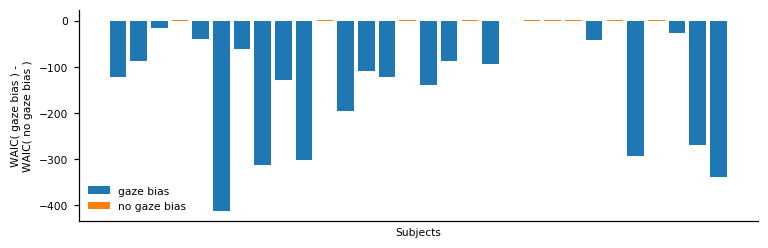

In [52]:
fig, ax = plt.subplots(1, 1, figsize=gb.plots.cm2inch(18,6), dpi=110)

ax.bar(subjects[gaze_bias_idx], dWAIC[gaze_bias_idx], color='C0', label='gaze bias')
ax.bar(subjects[no_gaze_bias_idx], dWAIC[no_gaze_bias_idx], color='C1', label='no gaze bias')
ax.set_xlabel('Subjects', fontsize=7)
ax.set_ylabel('WAIC( gaze bias )'+' -\n'+'WAIC( no gaze bias )', fontsize=7)
ax.legend(loc='lower left', frameon=False, fontsize=7)
ax.set_xticks([])
ax.tick_params(axis='both', which='major', labelsize=7)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

fig.tight_layout()

fig.savefig('examples/example_1/figures/relative_model_comparison.png', dpi=330)

We find that we recover correctly recover whether subjects have a gaze bias for 29 out of 30 subjects (as indicated by a lower WAIC score). We only flasly classify a single participant as having a gaze bias, even though we simulated the participant's choices without a gaze bias. 

In [53]:
no_gaze_bias_subjects

array([ 3, 10, 14, 17, 19, 20, 21, 22, 24, 26])

In [54]:
subjects[no_gaze_bias_idx]

array([ 3, 10, 14, 17, 20, 21, 22, 24, 26])

In [56]:
[s in subjects[no_gaze_bias_idx] for s in no_gaze_bias_subjects]

[True, True, True, True, False, True, True, True, True, True]

When looking at the individual parameter estimates (defined as maximum-a-priori or MAP of the GLAM's posterior traces), we find that the individually fitted $\gamma$ values (see Fig. 3 A) cover a wide range between -1 and 1. We also find that $\gamma$ estimates are strongly correlated with individuals’ values on the behavioural gaze bias measure (see Fig. 3 B). Thereby, indicating that the strength of the association between individuals’ gaze allocation and choice behaviour strongly varies between individuals. 

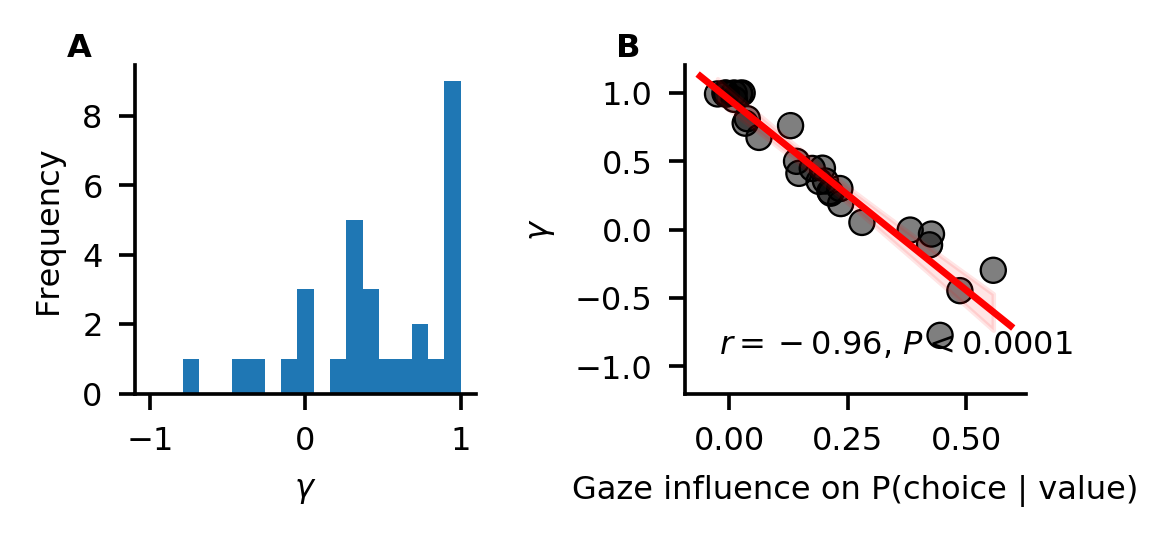

In [57]:
np.random.seed(10)

fig, axs = plt.subplots(1, 2, figsize=gb.plots.cm2inch(9, 4.5), dpi=330)

axs[0].hist(glam_bias.estimates['gamma'], bins=np.linspace(-1., 1, 20))
gb.plots.plot_correlation(subject_data_summary['gaze_influence'],
                          glam_bias.estimates['gamma'],
                          ax=axs[1],
                          ylim=(-1.2, 1.2))

axs[0].set_ylabel('Frequency', fontsize=7)
axs[0].set_xlabel(r'$\gamma$', fontsize=7)
axs[0].tick_params(axis='both', which='major', labelsize=7)
axs[0].spines['top'].set_visible(False)
axs[0].spines['right'].set_visible(False)
axs[1].set_ylabel(r'$\gamma$', fontsize=7)
axs[1].set_xlabel('Gaze influence on P(choice | value)', fontsize=7)
axs[1].tick_params(axis='both', which='major', labelsize=7)
for ax, label in zip(axs.ravel(), list('AB')):
    ax.text(-0.2,
            1.1,
            label,
            transform=ax.transAxes,
            fontsize=7,
            fontweight='bold',
            va='top')

fig.tight_layout()

fig.savefig('examples/example_1/figures/Figure_3_gaze_bias_estimates.png', dpi=330)

#### 3.2 Absolute Model Fit

Our likelihood-based model comparison has tested whether the response behaviour of each individual in the data is better described by a GLAM variant with or without gaze bias. Yet, it did not indicate whether the GLAM also represents a good model of their response behaviour on an absolute level. To test this, we further perform an out-of-sample prediction exersice.

First, we divide the data of each subject into the even- and odd-numbered experiment trials:

In [58]:
data_even = data[(data['trial']%2)==0].copy()
data_odd = data[(data['trial']%2)!=0].copy()

In [59]:
np.random.seed(11)

glam_bias.exchange_data(data_even)
glam_bias.fit(method='MCMC',
              tune=n_tune,
              draws=n_draws,
              chains=n_chains)

Replaced attached data (9000 trials) with new data (4500 trials)...
Fitting 30 model(s) using MCMC...
  Fitting model 1 of 30...


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [s]
>Metropolis: [gamma]
>Metropolis: [v]
Sampling 4 chains: 100%|██████████| 40000/40000 [00:34<00:00, 1169.99draws/s]
The number of effective samples is smaller than 10% for some parameters.


  Fitting model 2 of 30...


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [s]
>Metropolis: [gamma]
>Metropolis: [v]
Sampling 4 chains: 100%|██████████| 40000/40000 [00:32<00:00, 1223.64draws/s]
The number of effective samples is smaller than 10% for some parameters.


  Fitting model 3 of 30...


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [s]
>Metropolis: [gamma]
>Metropolis: [v]
Sampling 4 chains: 100%|██████████| 40000/40000 [00:31<00:00, 1271.52draws/s]
The number of effective samples is smaller than 10% for some parameters.


  Fitting model 4 of 30...


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [s]
>Metropolis: [gamma]
>Metropolis: [v]
Sampling 4 chains: 100%|██████████| 40000/40000 [00:31<00:00, 1279.71draws/s]
The number of effective samples is smaller than 10% for some parameters.


  Fitting model 5 of 30...


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [s]
>Metropolis: [gamma]
>Metropolis: [v]
Sampling 4 chains: 100%|██████████| 40000/40000 [00:31<00:00, 1277.87draws/s]
The number of effective samples is smaller than 10% for some parameters.


  Fitting model 6 of 30...


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [s]
>Metropolis: [gamma]
>Metropolis: [v]
Sampling 4 chains: 100%|██████████| 40000/40000 [00:31<00:00, 1268.69draws/s]
The number of effective samples is smaller than 10% for some parameters.


  Fitting model 7 of 30...


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [s]
>Metropolis: [gamma]
>Metropolis: [v]
Sampling 4 chains: 100%|██████████| 40000/40000 [00:31<00:00, 1286.30draws/s]
The number of effective samples is smaller than 10% for some parameters.


  Fitting model 8 of 30...


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [s]
>Metropolis: [gamma]
>Metropolis: [v]
Sampling 4 chains: 100%|██████████| 40000/40000 [00:31<00:00, 1279.16draws/s]
The number of effective samples is smaller than 10% for some parameters.


  Fitting model 9 of 30...


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [s]
>Metropolis: [gamma]
>Metropolis: [v]
Sampling 4 chains: 100%|██████████| 40000/40000 [00:31<00:00, 1274.89draws/s]
The number of effective samples is smaller than 10% for some parameters.


  Fitting model 10 of 30...


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [s]
>Metropolis: [gamma]
>Metropolis: [v]
Sampling 4 chains: 100%|██████████| 40000/40000 [00:31<00:00, 1281.95draws/s]
The number of effective samples is smaller than 10% for some parameters.


  Fitting model 11 of 30...


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [s]
>Metropolis: [gamma]
>Metropolis: [v]
Sampling 4 chains: 100%|██████████| 40000/40000 [00:31<00:00, 1268.59draws/s]
The number of effective samples is smaller than 10% for some parameters.


  Fitting model 12 of 30...


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [s]
>Metropolis: [gamma]
>Metropolis: [v]
Sampling 4 chains: 100%|██████████| 40000/40000 [00:31<00:00, 1271.31draws/s]
The number of effective samples is smaller than 10% for some parameters.


  Fitting model 13 of 30...


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [s]
>Metropolis: [gamma]
>Metropolis: [v]
Sampling 4 chains: 100%|██████████| 40000/40000 [00:31<00:00, 1287.66draws/s]
The number of effective samples is smaller than 10% for some parameters.


  Fitting model 14 of 30...


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [s]
>Metropolis: [gamma]
>Metropolis: [v]
Sampling 4 chains: 100%|██████████| 40000/40000 [00:31<00:00, 1276.58draws/s]
The number of effective samples is smaller than 10% for some parameters.


  Fitting model 15 of 30...


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [s]
>Metropolis: [gamma]
>Metropolis: [v]
Sampling 4 chains: 100%|██████████| 40000/40000 [00:31<00:00, 1278.21draws/s]
The number of effective samples is smaller than 10% for some parameters.


  Fitting model 16 of 30...


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [s]
>Metropolis: [gamma]
>Metropolis: [v]
Sampling 4 chains: 100%|██████████| 40000/40000 [00:31<00:00, 1279.58draws/s]
The number of effective samples is smaller than 25% for some parameters.


  Fitting model 17 of 30...


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [s]
>Metropolis: [gamma]
>Metropolis: [v]
Sampling 4 chains: 100%|██████████| 40000/40000 [00:31<00:00, 1270.47draws/s]
The number of effective samples is smaller than 10% for some parameters.


  Fitting model 18 of 30...


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [s]
>Metropolis: [gamma]
>Metropolis: [v]
Sampling 4 chains: 100%|██████████| 40000/40000 [00:31<00:00, 1280.56draws/s]
The number of effective samples is smaller than 10% for some parameters.


  Fitting model 19 of 30...


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [s]
>Metropolis: [gamma]
>Metropolis: [v]
Sampling 4 chains: 100%|██████████| 40000/40000 [00:31<00:00, 1286.94draws/s]
The number of effective samples is smaller than 10% for some parameters.


  Fitting model 20 of 30...


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [s]
>Metropolis: [gamma]
>Metropolis: [v]
Sampling 4 chains: 100%|██████████| 40000/40000 [00:31<00:00, 1278.56draws/s]
The number of effective samples is smaller than 10% for some parameters.


  Fitting model 21 of 30...


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [s]
>Metropolis: [gamma]
>Metropolis: [v]
Sampling 4 chains: 100%|██████████| 40000/40000 [00:30<00:00, 1307.16draws/s]
The number of effective samples is smaller than 25% for some parameters.


  Fitting model 22 of 30...


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [s]
>Metropolis: [gamma]
>Metropolis: [v]
Sampling 4 chains: 100%|██████████| 40000/40000 [00:31<00:00, 1286.30draws/s]
The number of effective samples is smaller than 10% for some parameters.


  Fitting model 23 of 30...


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [s]
>Metropolis: [gamma]
>Metropolis: [v]
Sampling 4 chains: 100%|██████████| 40000/40000 [00:31<00:00, 1273.71draws/s]
The number of effective samples is smaller than 10% for some parameters.


  Fitting model 24 of 30...


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [s]
>Metropolis: [gamma]
>Metropolis: [v]
Sampling 4 chains: 100%|██████████| 40000/40000 [00:31<00:00, 1283.06draws/s]
The number of effective samples is smaller than 10% for some parameters.


  Fitting model 25 of 30...


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [s]
>Metropolis: [gamma]
>Metropolis: [v]
Sampling 4 chains: 100%|██████████| 40000/40000 [00:30<00:00, 1292.89draws/s]
The number of effective samples is smaller than 10% for some parameters.


  Fitting model 26 of 30...


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [s]
>Metropolis: [gamma]
>Metropolis: [v]
Sampling 4 chains: 100%|██████████| 40000/40000 [00:31<00:00, 1277.71draws/s]
The number of effective samples is smaller than 10% for some parameters.


  Fitting model 27 of 30...


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [s]
>Metropolis: [gamma]
>Metropolis: [v]
Sampling 4 chains: 100%|██████████| 40000/40000 [00:31<00:00, 1261.56draws/s]
The number of effective samples is smaller than 10% for some parameters.


  Fitting model 28 of 30...


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [s]
>Metropolis: [gamma]
>Metropolis: [v]
Sampling 4 chains: 100%|██████████| 40000/40000 [00:31<00:00, 1281.65draws/s]
The number of effective samples is smaller than 10% for some parameters.


  Fitting model 29 of 30...


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [s]
>Metropolis: [gamma]
>Metropolis: [v]
Sampling 4 chains: 100%|██████████| 40000/40000 [00:31<00:00, 1271.98draws/s]
The number of effective samples is smaller than 10% for some parameters.


  Fitting model 30 of 30...


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [s]
>Metropolis: [gamma]
>Metropolis: [v]
Sampling 4 chains: 100%|██████████| 40000/40000 [00:31<00:00, 1268.38draws/s]
The number of effective samples is smaller than 10% for some parameters.


/!\ Automatically setting parameter precision...


In [60]:
np.random.seed(12)

glam_nobias.exchange_data(data_even)
glam_nobias.fit(method='MCMC',
                tune=n_tune,
                draws=n_draws,
                chains=n_chains)

Replaced attached data (9000 trials) with new data (4500 trials)...
Fitting 30 model(s) using MCMC...
  Fitting model 1 of 30...


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [s]
>Metropolis: [v]
Sampling 4 chains: 100%|██████████| 40000/40000 [00:20<00:00, 1916.18draws/s]
The number of effective samples is smaller than 10% for some parameters.


  Fitting model 2 of 30...


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [s]
>Metropolis: [v]
Sampling 4 chains: 100%|██████████| 40000/40000 [00:20<00:00, 1935.55draws/s]
The number of effective samples is smaller than 10% for some parameters.


  Fitting model 3 of 30...


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [s]
>Metropolis: [v]
Sampling 4 chains: 100%|██████████| 40000/40000 [00:20<00:00, 1926.12draws/s]
The number of effective samples is smaller than 10% for some parameters.


  Fitting model 4 of 30...


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [s]
>Metropolis: [v]
Sampling 4 chains: 100%|██████████| 40000/40000 [00:20<00:00, 1923.53draws/s]
The number of effective samples is smaller than 10% for some parameters.


  Fitting model 5 of 30...


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [s]
>Metropolis: [v]
Sampling 4 chains: 100%|██████████| 40000/40000 [00:20<00:00, 1927.32draws/s]
The number of effective samples is smaller than 10% for some parameters.


  Fitting model 6 of 30...


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [s]
>Metropolis: [v]
Sampling 4 chains: 100%|██████████| 40000/40000 [00:20<00:00, 1939.52draws/s]
The number of effective samples is smaller than 10% for some parameters.


  Fitting model 7 of 30...


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [s]
>Metropolis: [v]
Sampling 4 chains: 100%|██████████| 40000/40000 [00:20<00:00, 1928.49draws/s]
The number of effective samples is smaller than 10% for some parameters.


  Fitting model 8 of 30...


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [s]
>Metropolis: [v]
Sampling 4 chains: 100%|██████████| 40000/40000 [00:20<00:00, 1944.04draws/s]
The number of effective samples is smaller than 10% for some parameters.


  Fitting model 9 of 30...


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [s]
>Metropolis: [v]
Sampling 4 chains: 100%|██████████| 40000/40000 [00:20<00:00, 1944.95draws/s]
The number of effective samples is smaller than 25% for some parameters.


  Fitting model 10 of 30...


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [s]
>Metropolis: [v]
Sampling 4 chains: 100%|██████████| 40000/40000 [00:20<00:00, 1934.32draws/s]
The number of effective samples is smaller than 10% for some parameters.


  Fitting model 11 of 30...


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [s]
>Metropolis: [v]
Sampling 4 chains: 100%|██████████| 40000/40000 [00:20<00:00, 1914.56draws/s]
The number of effective samples is smaller than 10% for some parameters.


  Fitting model 12 of 30...


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [s]
>Metropolis: [v]
Sampling 4 chains: 100%|██████████| 40000/40000 [00:20<00:00, 1927.79draws/s]
The number of effective samples is smaller than 10% for some parameters.


  Fitting model 13 of 30...


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [s]
>Metropolis: [v]
Sampling 4 chains: 100%|██████████| 40000/40000 [00:20<00:00, 1931.46draws/s]
The number of effective samples is smaller than 10% for some parameters.


  Fitting model 14 of 30...


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [s]
>Metropolis: [v]
Sampling 4 chains: 100%|██████████| 40000/40000 [00:20<00:00, 1923.61draws/s]
The number of effective samples is smaller than 10% for some parameters.


  Fitting model 15 of 30...


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [s]
>Metropolis: [v]
Sampling 4 chains: 100%|██████████| 40000/40000 [00:20<00:00, 1926.58draws/s]
The number of effective samples is smaller than 10% for some parameters.


  Fitting model 16 of 30...


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [s]
>Metropolis: [v]
Sampling 4 chains: 100%|██████████| 40000/40000 [00:20<00:00, 1925.35draws/s]
The number of effective samples is smaller than 10% for some parameters.


  Fitting model 17 of 30...


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [s]
>Metropolis: [v]
Sampling 4 chains: 100%|██████████| 40000/40000 [00:20<00:00, 1940.44draws/s]
The number of effective samples is smaller than 10% for some parameters.


  Fitting model 18 of 30...


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [s]
>Metropolis: [v]
Sampling 4 chains: 100%|██████████| 40000/40000 [00:20<00:00, 1923.64draws/s]
The number of effective samples is smaller than 10% for some parameters.


  Fitting model 19 of 30...


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [s]
>Metropolis: [v]
Sampling 4 chains: 100%|██████████| 40000/40000 [00:20<00:00, 1919.02draws/s]
The number of effective samples is smaller than 10% for some parameters.


  Fitting model 20 of 30...


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [s]
>Metropolis: [v]
Sampling 4 chains: 100%|██████████| 40000/40000 [00:20<00:00, 1935.94draws/s]
The number of effective samples is smaller than 10% for some parameters.


  Fitting model 21 of 30...


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [s]
>Metropolis: [v]
Sampling 4 chains: 100%|██████████| 40000/40000 [00:19<00:00, 2016.08draws/s]
The number of effective samples is smaller than 25% for some parameters.


  Fitting model 22 of 30...


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [s]
>Metropolis: [v]
Sampling 4 chains: 100%|██████████| 40000/40000 [00:20<00:00, 1953.99draws/s]
The number of effective samples is smaller than 10% for some parameters.


  Fitting model 23 of 30...


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [s]
>Metropolis: [v]
Sampling 4 chains: 100%|██████████| 40000/40000 [00:20<00:00, 1944.47draws/s]
The number of effective samples is smaller than 10% for some parameters.


  Fitting model 24 of 30...


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [s]
>Metropolis: [v]
Sampling 4 chains: 100%|██████████| 40000/40000 [00:20<00:00, 1970.87draws/s]
The number of effective samples is smaller than 10% for some parameters.


  Fitting model 25 of 30...


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [s]
>Metropolis: [v]
Sampling 4 chains: 100%|██████████| 40000/40000 [00:20<00:00, 1975.37draws/s]
The number of effective samples is smaller than 10% for some parameters.


  Fitting model 26 of 30...


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [s]
>Metropolis: [v]
Sampling 4 chains: 100%|██████████| 40000/40000 [00:20<00:00, 1992.38draws/s]
The number of effective samples is smaller than 10% for some parameters.


  Fitting model 27 of 30...


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [s]
>Metropolis: [v]
Sampling 4 chains: 100%|██████████| 40000/40000 [00:20<00:00, 1933.80draws/s]
The number of effective samples is smaller than 10% for some parameters.


  Fitting model 28 of 30...


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [s]
>Metropolis: [v]
Sampling 4 chains: 100%|██████████| 40000/40000 [00:20<00:00, 1955.43draws/s]
The number of effective samples is smaller than 10% for some parameters.


  Fitting model 29 of 30...


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [s]
>Metropolis: [v]
Sampling 4 chains: 100%|██████████| 40000/40000 [00:20<00:00, 1967.54draws/s]
The number of effective samples is smaller than 10% for some parameters.


  Fitting model 30 of 30...


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [s]
>Metropolis: [v]
Sampling 4 chains: 100%|██████████| 40000/40000 [00:20<00:00, 1968.31draws/s]
The number of effective samples is smaller than 10% for some parameters.


/!\ Automatically setting parameter precision...


Again, we check all parameter traces for convergence, before preceeding further in the anlaysis:

In [61]:
np.all([check_convergence(pm.summary(trace), varnames=['v', 's', 'gamma', 'tau'])
        for trace in glam_bias.trace])

True

In [62]:
np.all([check_convergence(pm.summary(trace), varnames=['v', 's', 'tau'])
        for trace in glam_nobias.trace])

True

In [63]:
for subject, subject_trace in enumerate(glam_bias.trace):
    gb.plots.traceplot(subject_trace)
    plt.savefig('examples/example_1/results/out_of_sample/traces/sub_{}_gaze_bias_model_trace.png'.format(subject), dpi=330)
    plt.close()
    pm.trace_to_dataframe(subject_trace).to_csv(
        'examples/example_1/results/out_of_sample/traces/sub_{}_gaze_bias_model_trace.csv'.format(subject))

In [64]:
for subject, subject_trace in enumerate(glam_nobias.trace):
    gb.plots.traceplot(subject_trace)
    plt.savefig('examples/example_1/results/out_of_sample/traces/sub_{}_no_gaze_bias_model_trace.png'.format(subject), dpi=330)
    plt.close()
    pm.trace_to_dataframe(subject_trace).to_csv(
        'examples/example_1/results/out_of_sample/traces/sub_{}_no_gaze_bias_model_trace.csv'.format(subject))

After establishing convergence of all parameter traces, we utilize the individually estimated models to predict choices and response times for each trial in the held-out dataset (containing all odd-numbered experiment trials). In this simulation, we repeat each trial 50 times in order to gain a stable estimate of the GLAM's response behaviour:

In [65]:
n_repeats = 50

In [66]:
np.random.seed(13)

glam_bias.exchange_data(data_odd)
glam_bias.predict(n_repeats=n_repeats)
glam_bias.prediction.to_csv('examples/example_1/results/out_of_sample/predictions/gaze_bias_model_predictions.csv')

  0%|          | 0/4500 [00:00<?, ?it/s]

Replaced attached data (4500 trials) with new data (4500 trials)...
Generating predictions for 4500 trials (50 repeats each)...


100%|██████████| 4500/4500 [57:15<00:00,  1.31it/s]


In [67]:
np.random.seed(14)

glam_nobias.exchange_data(data_odd)
glam_nobias.predict(n_repeats=n_repeats)
glam_nobias.prediction.to_csv('examples/example_1/results/out_of_sample/predictions/no_gaze_bias_model_predictions.csv')

  0%|          | 0/4500 [00:00<?, ?it/s]

Replaced attached data (4500 trials) with new data (4500 trials)...
Generating predictions for 4500 trials (50 repeats each)...


100%|██████████| 4500/4500 [57:29<00:00,  1.30it/s]


Again, we aggregate the predictions of both model variants on the individual level by the use of the *aggregate_subject_level_data* function:

In [68]:
np.random.seed(15)

glam_bias_pred_subject_summary = gb.analysis.aggregate_subject_level_data(glam_bias.prediction, n_items)
glam_bias_pred_subject_summary.head()

rt                                                              \
             mean       std       min       max        se        q1        q3   
subject                                                                         
0.0      1.307884  0.477346  0.149319  4.695398  0.005512  1.054377  1.442555   
1.0      2.084206  0.965445  0.352744  8.034195  0.011149  1.415186  2.510638   
2.0      1.764664  0.735116  0.436253  5.525945  0.008489  1.247677  2.109723   
3.0      1.488407  0.753379  0.392612  6.300784  0.008700  0.995199  1.750604   
4.0      2.238638  0.752848  0.021392  7.190382  0.008694  1.704491  2.675259   

                  best_chosen gaze_influence  
              iqr        mean                 
subject                                       
0.0      0.388178    0.765067       0.190753  
1.0      1.095453    0.724533       0.208395  
2.0      0.862046    0.848667       0.056497  
3.0      0.755406    0.926933       0.007580  
4.0      0.970768    0.842267       0.099605

In [69]:
np.random.seed(16)

glam_nobias_pred_subject_summary = gb.analysis.aggregate_subject_level_data(glam_nobias.prediction, n_items)
glam_nobias_pred_subject_summary.head()

rt                                                              \
             mean       std       min       max        se        q1        q3   
subject                                                                         
0.0      1.299220  0.502687  0.144995  4.705099  0.005805  1.022557  1.447308   
1.0      2.076235  0.934882  0.334679  7.525897  0.010796  1.421201  2.491926   
2.0      1.737219  0.711101  0.454603  6.668007  0.008212  1.240422  2.081207   
3.0      1.474508  0.730390  0.314882  6.404233  0.008434  0.998095  1.741055   
4.0      2.266835  0.779392  0.006069  7.074538  0.009000  1.731574  2.690155   

                  best_chosen gaze_influence  
              iqr        mean                 
subject                                       
0.0      0.424752    0.759200      -0.001471  
1.0      1.070725    0.708667       0.010627  
2.0      0.840785    0.853467      -0.000057  
3.0      0.742960    0.938267       0.003416  
4.0      0.958581    0.819867       0.006152

To then determine the absolute fit of both model variants to the data, we plot the individually predited against the individually observed data on our three behavioural metrics. To do this, we utilize the *plot_individual* function of the plots module. This function takes as input the observed data, as well as a list of the predictions of all model variants that are to be compared. For each model variant, the function creates a new row of panels, plotting the observed against the predicted data.

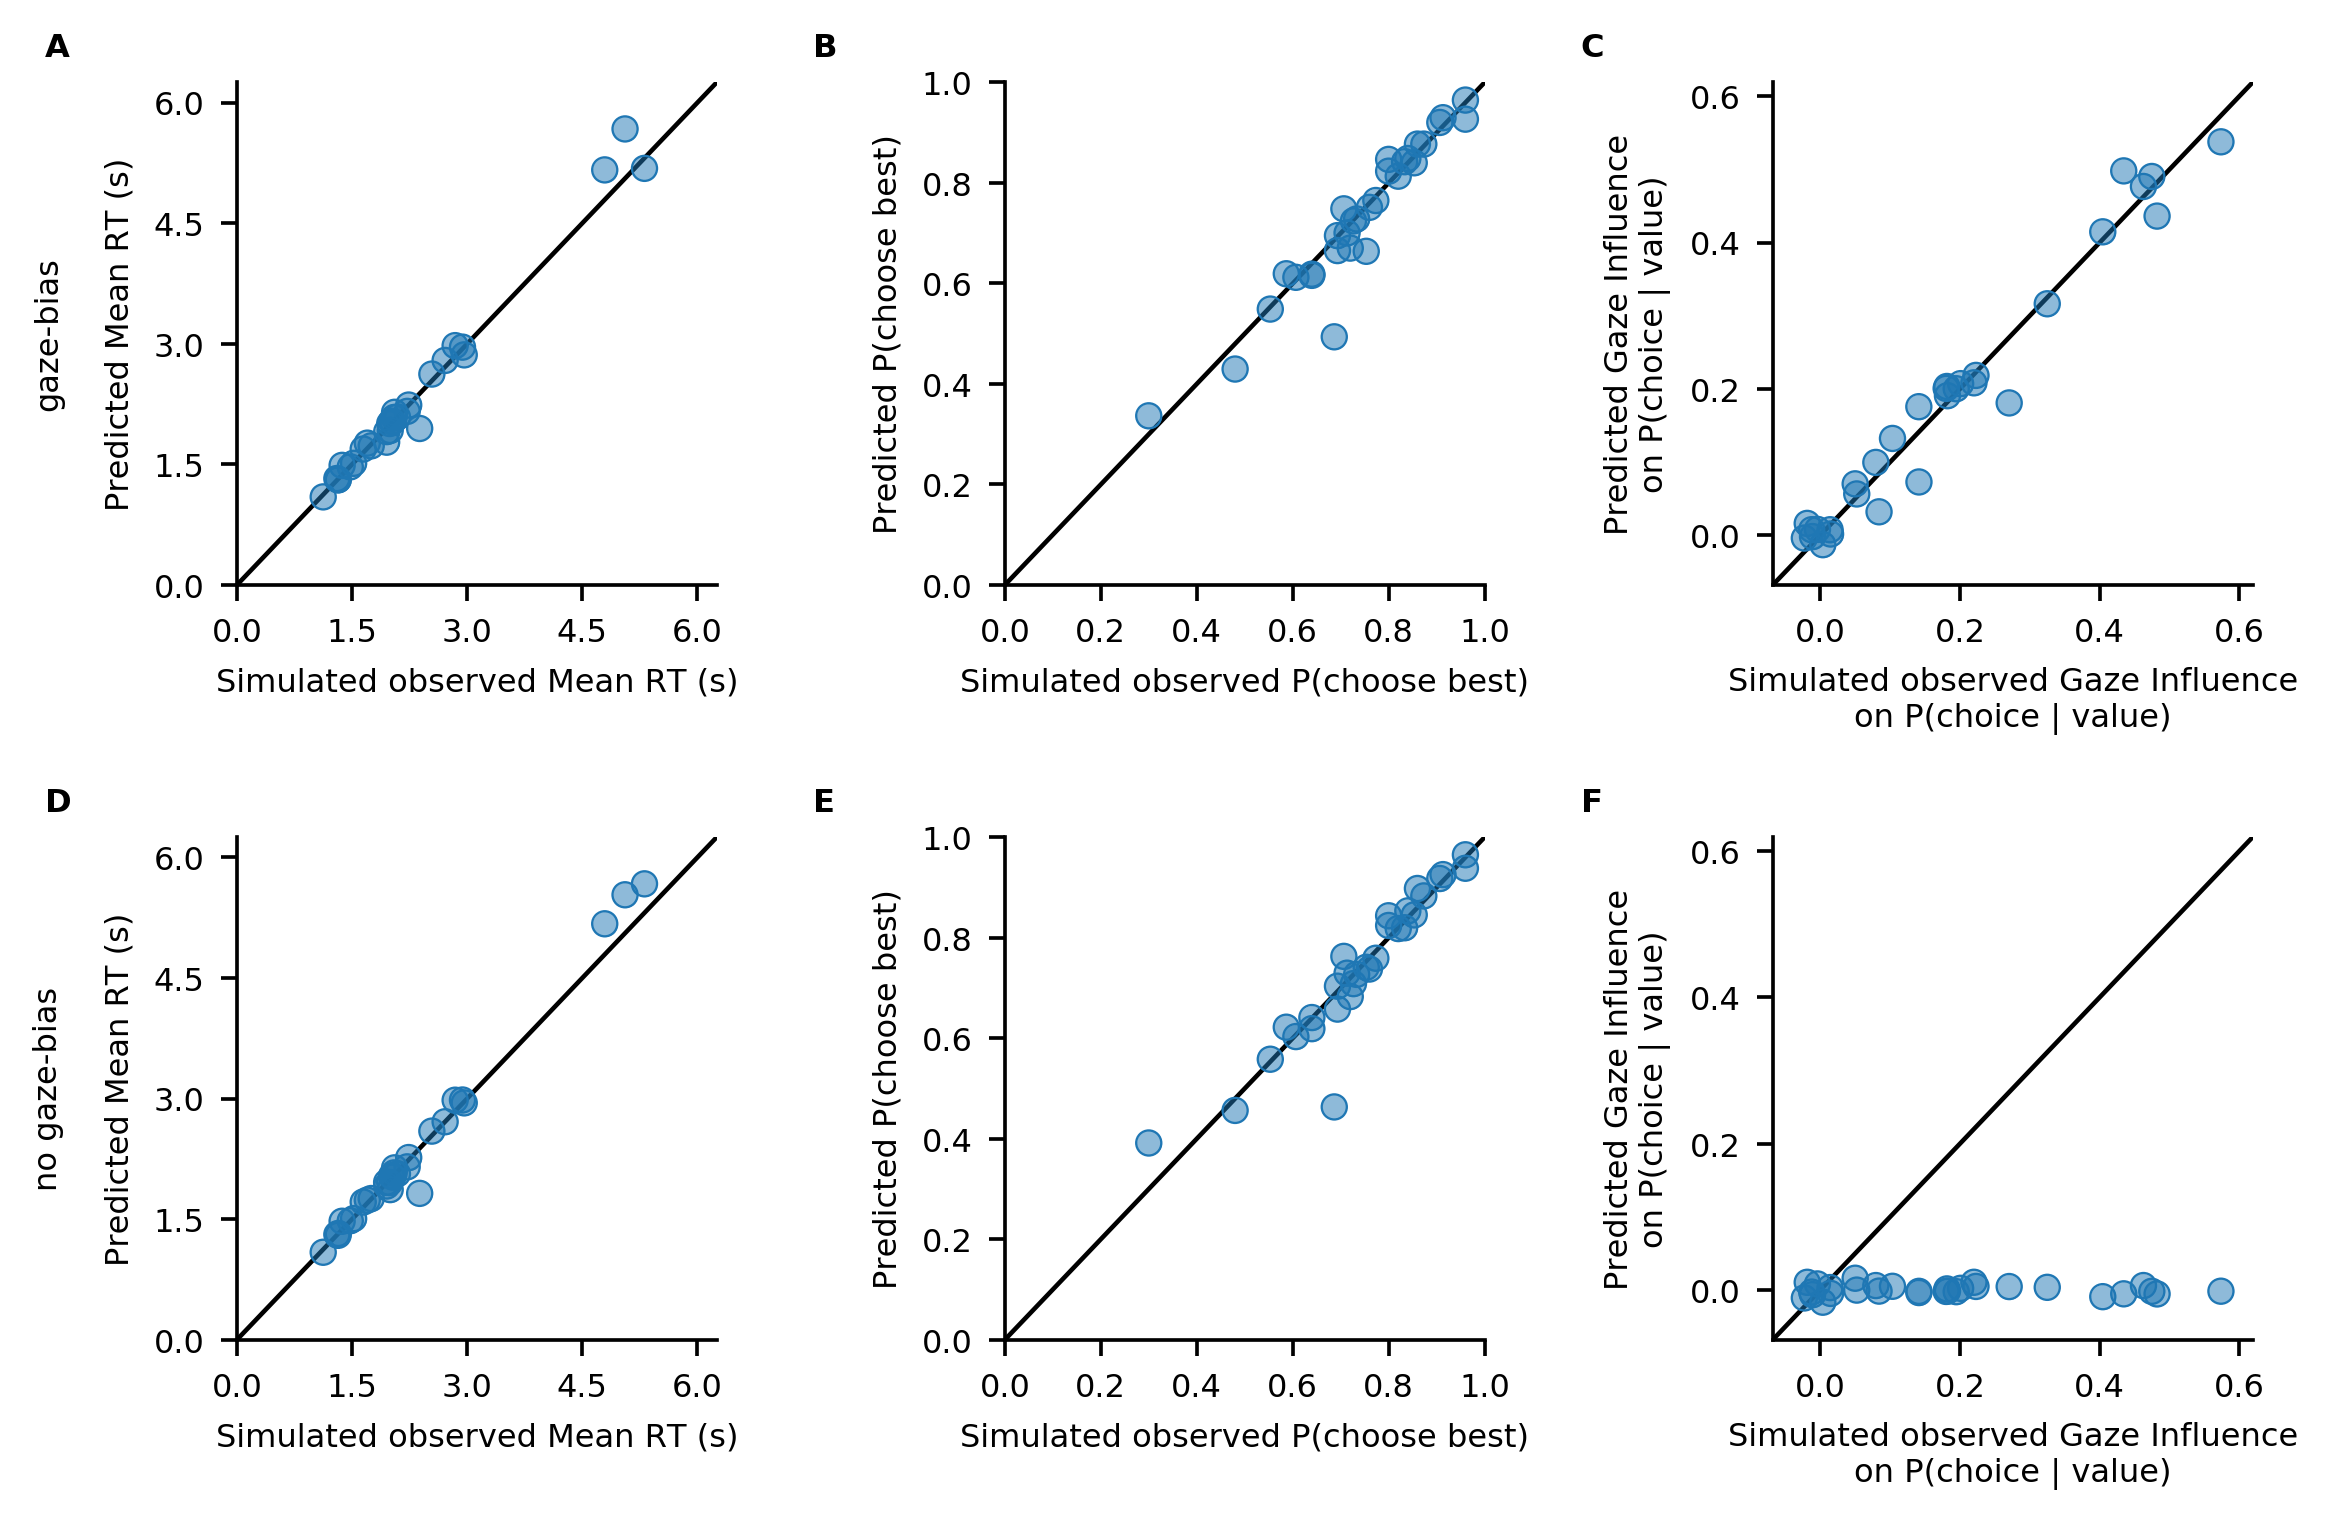

In [70]:
np.random.seed(17)

fig, axs = gb.plots.plot_individual_fit(observed=data_odd,
                                        predictions=[glam_bias.prediction,
                                                     glam_nobias.prediction],
                                        prediction_labels=['gaze-bias', 'no gaze-bias'])

# We'll change the xlabels to "Simulated observed", just to be clear that these are simulated data!
for ax in axs.ravel():
    xlabel = ax.get_xlabel()
    ax.set_xlabel('Simulated o' + xlabel[1:])

fig.savefig('examples/example_1/figures/Figure_4_absolute_fit.png', dpi=330)

Both model variants perform well in capturing individuals' response times and probability of choosing the best item. Yet, only the GLAM variant with gaze bias is able to also recover the strength of the association between individuals' choice behaviour and gaze allocation.